In [1]:
#!/usr/bin/python
'''
 Rehder, Bob, and Aaron B. Hoffman. (2005). Thirty-Something Categorization
 Results Explained: Selective Attention, Eyetracking, and Models of Category
 Learning. Journal of Experimental Psychology: Learning, Memory, and Cognition
 31(5). 811–29. https://doi.org/10.1037/0278-7393.31.5.811.
'''

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import sys
sys.path.append('..')
import sea


In [2]:
# %% simulation parameters
param = {
    # how many steps one looksahead? 0 is myopic (1 step ahead) and so on..
    'MAX_RECURSION_LEVEL':  5,
    'EXPLORATION_PARAM':    0.0,
    'DECISION_PARAMETER':   1.0,
    'TOTAL_BLOCKS':         21,
    'CONSEC_BLOCKS':        2,
    'prior_matrix':         np.array([[.01, .01],
                              [1.0, 1.0],
                              [1.0, 1.0, ],
                              [1.0, 1.0],
                              [1.0, 1.0]]),
    'num_dims':             5,
    'num_values':           2,
    'coupling':             .3,
    'd':                    1.0,
    'report':               False,
    'NUM_TIMES'				: 5  # nreps of the six problems
}


# uses a binary feature (one unit) for the first three dims and two
# features for the output to facillitate choice.
MS_STIM = np.array([[0, 1, 1, 1, 0],
                    [0, 1, 0, 1, 0],
                    [0, 1, 0, 1, 1],
                    [0, 1, 1, 0, 1],
                    [0, 0, 1, 1, 1],
                    [1, 1, 1, 0, 0],
                    [1, 0, 1, 1, 0],
                    [1, 0, 0, 0, 1],
                    [1, 0, 0, 0, 0]])

MS_TRANS_STIM = np.array([[0, 1, 0, 0, 1],
                          [0, 1, 0, 0, 0],
                          [0, 1, 1, 1, 1],
                          [0, 0, 0, 1, 0],
                          [0, 0, 1, 0, 1],
                          [0, 0, 0, 1, 1],
                          [0, 0, 1, 0, 0]])


# features known during stimulus presentation
MS_KNOWN = np.array([0, 1, 1, 1, 1])

MS_QUERY = np.array([1, 0, 0, 0, 0])


# functions for computing utility:


def getSituationCost(KNOWN_VEC, param):
    '''function to calculate costs for a given KNOWN_VEC (see RMC.SituationValue)

    This function assumes equal costs for each query. Can be modified for
    tasks in which some tests are more costly than others, or when sampling costs
    are not independent.'''
    return np.sum(KNOWN_VEC) * 10


def dfActionVals(param):
    '''function to define utility table (e.g., table 1)
    returns dataframe
    '''
    m = np.diag([100] * param['num_values'])
    df = pd.DataFrame(index=['s%d' % a for a in range(param['num_values'])],
                      columns=['a%d' % a for a in range(param['num_values'])],
                      data=m)
    return df


param['getSituationCost'] = getSituationCost
param['dfActionVals'] = dfActionVals(param)

In [3]:
# %%

model = sea.RMC(param)

blocks_correct_consec   = 0
overall_correct         = np.zeros([param['TOTAL_BLOCKS']])
overall_sampled         = np.zeros([param['TOTAL_BLOCKS']])
item_order              = np.arange(9)
totalTransDimSampled    = 0
dimSampledFirst         = np.array([0, 0, 0, 0])
transAccuracy           = 0
proportionTrialsSampled = np.array([0, 0, 0, 0, 0])
transferProbA           = np.zeros(16)
transSamplesAll         = np.array([0, 0, 0, 0])
transSampleFirst        = np.array([0, 0, 0, 0])
transItemSamples        = np.reshape(np.array(np.zeros(16 * 4)), (16, 4))
samplesByBlock          = np.zeros((param['TOTAL_BLOCKS'], 5))

allSamples = []


dfTransDimSampled = pd.DataFrame(
    index=range(param['NUM_TIMES'] *16),
    columns=['run', 'item', 'D1', 'D2',  'D3', 'D4'])

itrDimSamp = -1
for run_num in range(param['NUM_TIMES']):

    model.Reset()
    sim_correct = np.zeros(param['TOTAL_BLOCKS'])
    numberDimSampled = np.zeros(param['TOTAL_BLOCKS'])
    allSamples.append([])

    for num_block in tqdm(range(param['TOTAL_BLOCKS']),desc='run %d'%run_num):
        np.random.shuffle(item_order)
        blockCorrectProb = 1.0

        for wbi, item_num in enumerate(item_order):
            tempN = model.PresentStimulus(MS_STIM[item_num], MS_KNOWN)
            allSamples[run_num].append([item_num, tempN])
            dimSampledFirst[tempN[0] - 1] += 1

            SAMPLED_KNOWN = np.zeros(model.NUM_DIMS, dtype=int)
            SAMPLED_KNOWN[tempN] = 1

            proportionTrialsSampled += SAMPLED_KNOWN
            samplesByBlock[num_block] += SAMPLED_KNOWN

            numberDimSampled[num_block] += len(tempN)
            correctProb = model.ResponseCorrectProb(
                MS_STIM[item_num], SAMPLED_KNOWN)
            blockCorrectProb *= correctProb
            sim_correct[num_block] += correctProb
            model.Learn(MS_STIM[item_num], SAMPLED_KNOWN, MS_QUERY)

        if np.random.uniform(0, 1) < blockCorrectProb:
            blocks_correct_consec += 1
        else:
            blocks_correct_consec = 0

        if blocks_correct_consec == param['CONSEC_BLOCKS']:
            sim_correct[(num_block + 1):] = 9.
            numberDimSampled[(num_block +
                              1):] += float(numberDimSampled[num_block])

            # repeat eye fixation pattern from last block
            last9 = allSamples[run_num][-9:]
            last9 = last9 * (param['TOTAL_BLOCKS'] - (num_block + 1))
            allSamples[run_num] = allSamples[run_num] + last9
            break

    # TRANSFER ------------------------------------------------------------
    for item in range(16):
        if item < 9:
            tempN = model.PresentStimulus(MS_STIM[item], MS_KNOWN)
        else:
            tempN = model.PresentStimulus(MS_TRANS_STIM[item - 9], MS_KNOWN)

        for z in tempN:
            transItemSamples[item][z - 1] += 1

        transferProbA[item] += model.Fpredictions[0, 0]

        itrDimSamp += 1
        dfTransDimSampled.loc[itrDimSamp, :] = np.zeros(
            dfTransDimSampled.shape[1])
        dfTransDimSampled.loc[itrDimSamp, ['run', 'item']] = run_num, item

        SAMPLED_KNOWN = np.zeros(model.NUM_DIMS, dtype=int)
        SAMPLED_KNOWN[tempN] = 1
        transSamplesAll += SAMPLED_KNOWN[1:]
        dfTransDimSampled.loc[itrDimSamp, [
            'D1', 'D2', 'D3', 'D4']] += SAMPLED_KNOWN[1:]
        transSampleFirst[tempN[0] - 1] += 1

    overall_correct += sim_correct
    overall_sampled += numberDimSampled

print('overall_sampled', overall_sampled / (param['NUM_TIMES'] * 9))
print('pc correct by block:', overall_correct / (param['NUM_TIMES'] * 9))



run 3: 100%|██████████| 21/21 [00:31<00:00,  1.52s/it]

run 4: 100%|██████████| 21/21 [00:31<00:00,  1.41s/it]


overall_sampled [3.31111111 2.88888889 2.82222222 2.6        2.68888889 2.55555556
 2.6        2.64444444 2.57777778 2.44444444 2.48888889 2.55555556
 2.53333333 2.51111111 2.48888889 2.44444444 2.46666667 2.53333333
 2.53333333 2.57777778 2.42222222]
pc correct by block: [0.50280997 0.60882222 0.66068412 0.73836801 0.74129398 0.7745792
 0.82425719 0.84263004 0.84455623 0.84783091 0.86046067 0.85740983
 0.86736932 0.86346568 0.87033696 0.86399704 0.88451996 0.87461786
 0.89396432 0.88390267 0.86490424]



dims sampled at transfer by item: 
[[0.8 0.2 0.8 0.6]
 [1.  0.2 0.8 0.6]
 [0.8 0.  1.  0.2]
 [0.6 0.4 0.8 1. ]
 [0.4 0.2 0.8 1. ]
 [0.6 0.4 0.6 0.8]
 [1.  0.2 0.4 1. ]
 [0.6 0.4 1.  0.4]
 [0.6 0.  1.  0.4]
 [0.6 0.4 0.8 0.6]
 [0.6 0.2 1.  0.8]
 [0.6 0.2 0.4 0.6]
 [0.8 0.4 1.  0.8]
 [0.8 0.2 1.  0.6]
 [1.  0.  1.  1. ]
 [0.6 0.  1.  0.4]]

mean accuracy during training: 0.808
mean sampled during training: 2.646
mean sampling during transfer:  [0.7125 0.2125 0.8375 0.675 ]


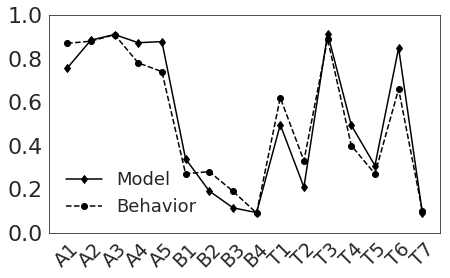

In [5]:
# %% plotting

rehder_choice_data = np.array([
    [0.83, 0.87, 0.77],
    [0.82, 0.88, 0.79],
    [0.89, 0.91, 0.84],
    [0.79, 0.78, 0.71],
    [0.74, 0.74, 0.69],
    [0.3, 0.27, 0.34],
    [0.28, 0.28, 0.34],
    [0.15, 0.19, 0.27],
    [0.11, 0.09, 0.18],
    [0.62, 0.62, 0.59],
    [0.4, 0.33, 0.37],
    [0.88, 0.89, 0.78],
    [0.34, 0.4, 0.41],
    [0.4, 0.27, 0.33],
    [0.55, 0.66, 0.63],
    [0.17, 0.1, 0.23]])


plt.close('all')
sns.set_style('white')


def plot54(y, label=''):
    xtickSize   = 19
    ytickSize   = 22
    linestyles  = ['-', '--']
    markers     = ['d', 'o']
    plt.plot(range(1, 17), y, label=label, color='k',
             linestyle=linestyles['eh' in label],
             marker=markers['eh' in label])
    plt.xticks(range(1, 17),
               ['A1', 'A2', 'A3', 'A4', 'A5',
                'B1', 'B2', 'B3', 'B4',
                'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'],
               fontsize=xtickSize,
               rotation=45)
    plt.yticks(np.arange(
                0, 1.1, .2), np.arange(
                0, 1.01, .2).round(2), fontsize=ytickSize)


print("\ndims sampled at transfer by item: ")
transItemSamplesNormed = transItemSamples / (1.0 * param['NUM_TIMES'])
print(transItemSamplesNormed)

print("\nmean accuracy during training: %.3f"%(np.average(
    overall_correct) / (9. * param['NUM_TIMES'])))
print("mean sampled during training: %.3f"%(np.average(numberDimSampled) / (9.)))


print("mean sampling during transfer: ",
      transSamplesAll / (16. * param['NUM_TIMES']))

plt.figure(figsize=(7, 4))
plot54(transferProbA / param['NUM_TIMES'], label='Model')
plot54(rehder_choice_data[:, 1], label='Behavior')
legend = plt.legend(frameon=0, fontsize=18, loc=3)


